In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer

from nltk.translate.bleu_score import sentence_bleu
from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
MODELS = {
    "Gemma 1.1 - 2B":  "google/gemma-1.1-2b-it",
    "Gemma 1.1 - 7B":  "google/gemma-1.1-7b-it",
    "Gemma 2.0 - 9B":  "google/gemma-2-9b-it",
    "Gemma 2.0 - 27B": "google/gemma-2-27b-it",
    "Llama 3.1 - 8B":  "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "Llama 3.1 - 70B": "meta-llama/Meta-Llama-3.1-70B-Instruct",
    "Llama 3.2 - 1B":  "meta-llama/Llama-3.2-1B-Instruct",
    "Llama 3.2 - 3B":  "meta-llama/Llama-3.2-3B-Instruct",
    "Llama 3.3 - 70B": "meta-llama/Llama-3.3-70B-Instruct",
    "Falcon 1.0 - 7B": "tiiuae/Falcon-7B-Instruct",
    "Falcon 3.0 - 3B": "tiiuae/Falcon3-3B-Instruct",
    "Falcon 3.0 - 7B": "tiiuae/Falcon3-7B-Instruct",
    "Falcon 3.0 - 10B": "tiiuae/Falcon3-10B-Instruct"
}

PLOTS_DIR  = "plots"
K = 10

# Load results:

In [3]:
RESULTS = {}

for key in MODELS:
    t_start = time.time()
    with open(f'results/movies/{MODELS[key]}-self-counterfactuals.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)
    print(f'Loaded {key} ({len(RESULTS[key]):d} instances, dt={(time.time()-t_start)*1000:.2f} ms).')

Loaded Gemma 1.1 - 2B (200 instances, dt=8.06 ms).
Loaded Gemma 1.1 - 7B (200 instances, dt=8.38 ms).
Loaded Gemma 2.0 - 9B (200 instances, dt=8.83 ms).
Loaded Gemma 2.0 - 27B (200 instances, dt=217.47 ms).
Loaded Llama 3.1 - 8B (200 instances, dt=7.63 ms).
Loaded Llama 3.1 - 70B (200 instances, dt=6.97 ms).
Loaded Llama 3.2 - 1B (200 instances, dt=8.64 ms).
Loaded Llama 3.2 - 3B (200 instances, dt=8.05 ms).
Loaded Llama 3.3 - 70B (200 instances, dt=7.04 ms).
Loaded Falcon 1.0 - 7B (200 instances, dt=10.23 ms).
Loaded Falcon 3.0 - 3B (200 instances, dt=7.58 ms).
Loaded Falcon 3.0 - 7B (200 instances, dt=7.20 ms).
Loaded Falcon 3.0 - 10B (200 instances, dt=7.44 ms).


In [4]:
plotter = Plotter(RESULTS, i_sample=8, save_dir=PLOTS_DIR)
plotter.print_chat("Llama 3.1 - 8B")

\begin{tabular}{p{.05\linewidth}p{.1\linewidth}p{.8\linewidth}}

\hline

&
\textbf{user}: &
\texttt{What is the sentiment of the following review?

"At 84 minutes in length, I thought that I could enjoy a few laughs before getting a good nights sleep. But by my account, I think that my laff-o-meter only registered a few grins, one giggle, and maybe one chortle. I suppose that you could justify your time as homage to the venerable hollywood star, lloyd bridges, who just recently passed away and whose last performance was in this film."

Assign one of the following labels: "negative" or "positive". Make sure to answer only with the label or "none" if none of them applies.} \\

&
\textbf{assistant}: &
\texttt{negative} \\


\hline

\end{tabular}


# Performance:

In [5]:
for model in RESULTS:
    y_true = np.array([(item['label']['text'] == 'positive', item['label']['text'] == 'negative') for item in RESULTS[model]], dtype=float)
    y_pred = np.array([(item['prediction']['text'] == 'positive', item['prediction']['text'] == 'negative') for item in RESULTS[model]], dtype=float)

    print(model)
    print(f'  F1:           {f1_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  precision:    {precision_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  recall:       {recall_score(y_true, y_pred, average="macro"):.2f}')
    print()

Gemma 1.1 - 2B
  F1:           0.85
  precision:    0.92
  recall:       0.81

Gemma 1.1 - 7B
  F1:           0.91
  precision:    0.91
  recall:       0.91

Gemma 2.0 - 9B
  F1:           0.95
  precision:    0.97
  recall:       0.94

Gemma 2.0 - 27B
  F1:           0.95
  precision:    0.96
  recall:       0.95

Llama 3.1 - 8B
  F1:           0.96
  precision:    0.97
  recall:       0.96

Llama 3.1 - 70B
  F1:           0.96
  precision:    0.97
  recall:       0.96

Llama 3.2 - 1B
  F1:           0.85
  precision:    0.87
  recall:       0.85

Llama 3.2 - 3B
  F1:           0.89
  precision:    0.91
  recall:       0.88

Llama 3.3 - 70B
  F1:           0.96
  precision:    0.97
  recall:       0.96

Falcon 1.0 - 7B
  F1:           0.62
  precision:    0.93
  recall:       0.56

Falcon 3.0 - 3B
  F1:           0.88
  precision:    0.90
  recall:       0.88

Falcon 3.0 - 7B
  F1:           0.93
  precision:    0.94
  recall:       0.91

Falcon 3.0 - 10B
  F1:           0.96
  precis

# Self assessment:

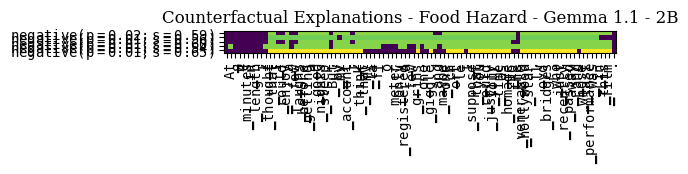

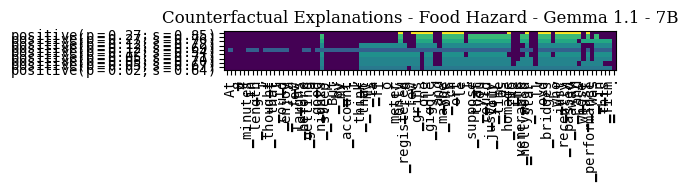

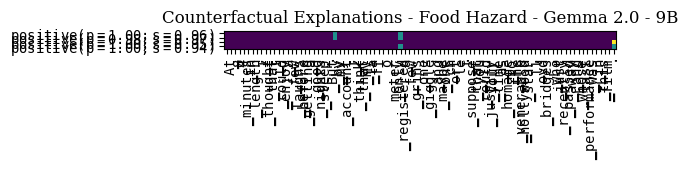

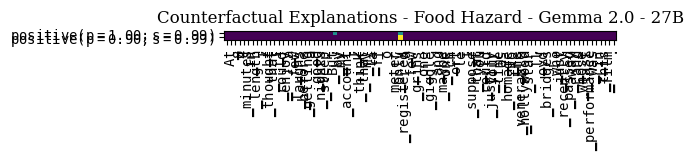

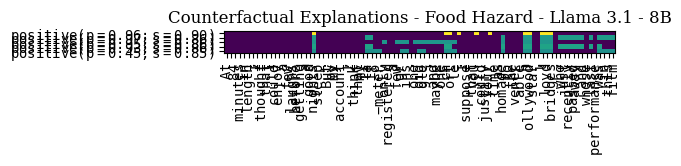

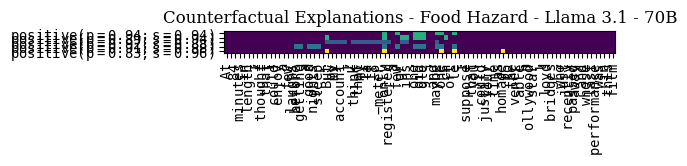

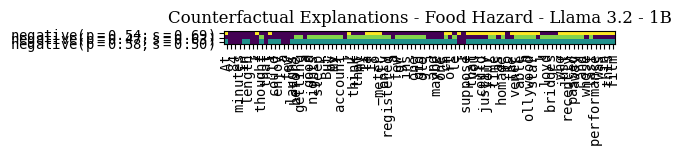

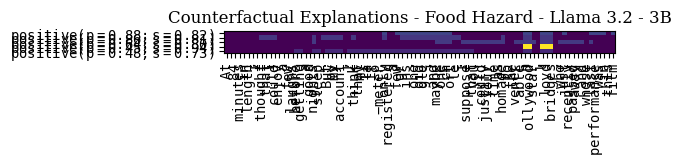

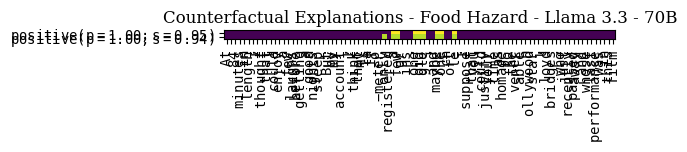

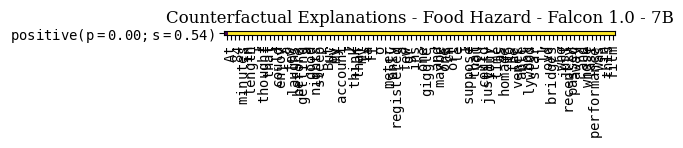

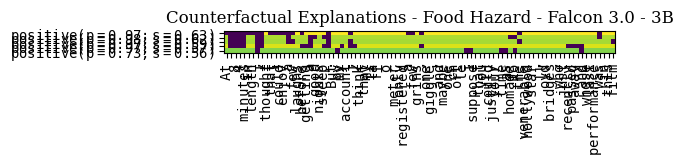

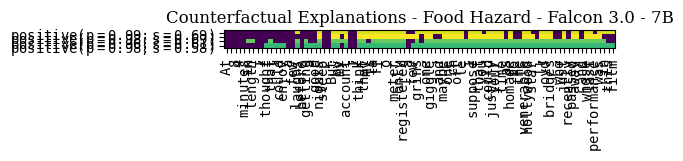

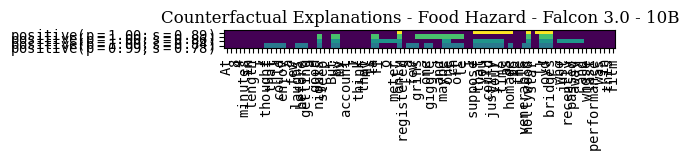

In [6]:
importance_cf = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']

        label_probs = [(label, r['counterfactuals'][label]['probability']) for label in r['counterfactuals']]
        label_probs.sort(key=lambda x: x[1], reverse=True)

        for cf_label, cf_probability in label_probs:
            probabilities = np.array([float(s['probability']) for s in r['counterfactuals'][cf_label]['samples']])
            similarities  = np.array([float(s['similarity']) for s in r['counterfactuals'][cf_label]['samples']])
            success       = np.array([cf_label in s['prediction'] for s in r['counterfactuals'][cf_label]['samples']])

            if success.any(): break

        importance_cf[model].append({})
        for i in np.argsort(probabilities*similarities*success.astype(bool))[::-1]:
            if not success[i]: continue

            cf = r['counterfactuals'][cf_label]['samples'][i]

            importance = np.zeros(length, dtype=float)
            for j,k in cf['spans']:
                importance[j-offset:k-offset] = 1.
            importance /= max(importance.sum(), 1e-9)

            importance_cf[model][-1][f'{cf_label} (p={probabilities[i]:.2f}; s={similarities[i]:.2f})'] = importance

plotter.plot_importance([importance_cf], [''], f'Counterfactual Explanations - Food Hazard')

### Produce best CF@$k$:

In [7]:
wp_tokenizer = WordPunctTokenizer()
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=wp_tokenizer)
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

counterfactuals  = {model:{i+1: [] for i in range(K)} for model in RESULTS}
path = 'results/movies/counterfactuals/'
os.makedirs(path, exist_ok=True)

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']

        label_probs = [(label, r['counterfactuals'][label]['probability']) for label in r['counterfactuals']]
        label_probs.sort(key=lambda x: x[1], reverse=True)

        dt = [0.]
        for cl, (cf_label, cf_probability) in enumerate(label_probs):
            probabilities = np.array([float(s['probability']) for s in r['counterfactuals'][cf_label]['samples']])
            similarities  = np.array([float(s['similarity']) for s in r['counterfactuals'][cf_label]['samples']])
            dt            = dt[-1] + np.cumsum([float(s['dt']) * 1e-9 for s in r['counterfactuals'][cf_label]['samples']])
            success       = np.array([cf_label in s['prediction'] for s in r['counterfactuals'][cf_label]['samples']])

            if success.any(): break

        scores  = (probabilities*similarities) - np.where(success, 0., 1.)
        for i in range(K):
            j = np.argmax(scores[:i+1])

            text = r['counterfactuals'][cf_label]['samples'][j]['text']
            bleu = sentence_bleu([wp_tokenizer.tokenize(r['sample']['text'].lower())], wp_tokenizer.tokenize(text.lower()))
            rouge = rouge_scorer.score(r['sample']['text'].lower(), text.lower())
            bart = bart_scorer.score([r['sample']['text']], [text.lower()], batch_size=4)

            counterfactuals[model][i+1].append({
                'text':        text,
                'prediction':  cf_label,
                'success':     success[j],
                'probability': probabilities[j],
                'similarity':  similarities[j],
                'bleu':        bleu,
                'rouge1-rec':  rouge['rouge1'].recall,
                'rouge1-prc':  rouge['rouge1'].precision,
                'rouge1-f1':   rouge['rouge1'].fmeasure,
                'rougeL-rec':  rouge['rougeL'].recall,
                'rougeL-prc':  rouge['rougeL'].precision,
                'rougeL-f1':   rouge['rougeL'].fmeasure,
                'bart-score':  bart[0],
                'spans':       r['counterfactuals'][cf_label]['samples'][j]['spans'],
                'dt':          dt[i] if i < len(dt) else np.nan,
                'best':        float(j),
                'best_class':  cl
            })

    for i in counterfactuals[model]:
        counterfactuals[model][i] = pd.DataFrame(counterfactuals[model][i])
        counterfactuals[model][i].to_csv(path + f'{model}-first{i:d}.csv')

/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

### OR load best CF@$k$:

In [7]:
counterfactuals  = {model:{i+1: [] for i in range(K)} for model in RESULTS}
path = 'results/movies/counterfactuals/'

for model in RESULTS:
    for i in counterfactuals[model]:
        counterfactuals[model][i] = pd.read_csv(path + f'{model}-first{i:d}.csv')

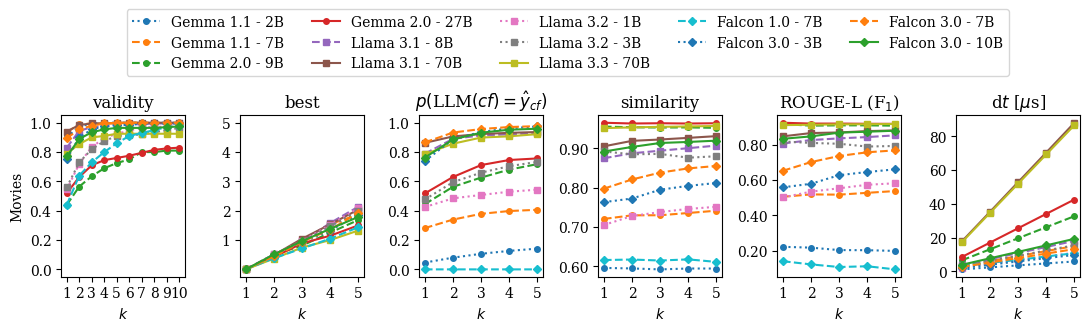

In [8]:
fig, axs = plt.subplots(1, 6, figsize=(11,3.5))
xs = np.arange(5)+1

markers = ['o']*4 + ['s']*5 + ['D']*4

for marker, model in zip(markers, RESULTS):
    size = int(model.split()[-1][:-1])
    if size <= 3:   linestyle = ':'
    elif size <= 9: linestyle = '--'
    else:           linestyle = '-'

    val  = [counterfactuals[model][i+1]['success'].mean() for i in range(K)]
    axs[0].plot(np.arange(K)+1, val, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[0].set_xticks(np.arange(K)+1)
    axs[0].set_xlabel('$k$')
    axs[0].set_title('validity')
    axs[0].set_ylim(-.05, 1.05)
    axs[0].set_yticks([0., .2, .4, .6, .8 , 1.])

    best  = [counterfactuals[model][i+1]['best'][counterfactuals[model][i+1]['success']].mean() for i in range(5)]
    axs[1].plot(xs, best, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[1].set_title('best')
    axs[1].set_ylim(-.25, 5.25)
    axs[1].set_yticks(xs)

    prob = [counterfactuals[model][i+1]['probability'].mean() for i in range(5)]
    axs[2].plot(xs, prob, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[2].set_title('$p($LLM$(cf) = \\hat{y}_{cf})$')
    axs[2].set_ylim(-.05, 1.05)
    axs[2].set_yticks([0., .2, .4, .6, .8 , 1.])

    sim  = [counterfactuals[model][i+1]['similarity'].mean() for i in range(5)]
    axs[3].plot(xs, sim, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[3].set_title('similarity')
    axs[3].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.2f}')
    )

    sim  = [counterfactuals[model][i+1]['rougeL-f1'].mean() for i in range(5)]
    axs[4].plot(xs, sim, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[4].set_title('ROUGE-L (F$_1$)')
    axs[4].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.2f}')
    )

    dt   = [counterfactuals[model][i+1]['dt'].mean() for i in range(5)]
    axs[5].plot(xs, dt, label=model, marker=marker, markersize=4, linestyle=linestyle)
    axs[5].set_title('d$t$ [$\mu$s]')
    axs[5].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.0f}')
    )

for ax in axs[1:]:
    ax.set_xticks(xs)
    ax.set_xlabel('$k$')

axs[0].set_ylabel('Movies')

plt.tight_layout(rect=(0, 0, 1, .75))
axs[2].legend(bbox_to_anchor=(.7, 1.2, 1, 1), loc='lower center', ncols=len(RESULTS)//3+1)
plt.savefig('plots/Counterfactuals-Movies.pdf')
plt.show()

## First candidate:

In [9]:
for model in counterfactuals: print(model, '\n', counterfactuals[model][1].describe(), '\n')

Gemma 1.1 - 2B 
        Unnamed: 0   probability  similarity           bleu  rouge1-rec  \
count  200.000000  2.000000e+02  200.000000   2.000000e+02  200.000000   
mean    99.500000  4.662130e-02    0.596097   4.936121e-02    0.259023   
std     57.879185  1.389902e-01    0.099311   1.005680e-01    0.123105   
min      0.000000  1.434237e-07    0.355685   0.000000e+00    0.000000   
25%     49.750000  4.058838e-03    0.531267  2.572045e-155    0.178853   
50%     99.500000  1.345825e-02    0.594880   1.094629e-78    0.241902   
75%    149.250000  3.405762e-02    0.661714   6.563623e-02    0.314620   
max    199.000000  8.789062e-01    0.876847   6.338566e-01    0.786885   

       rouge1-prc   rouge1-f1  rougeL-rec  rougeL-prc   rougeL-f1  bart-score  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.417071    0.307847    0.187685    0.299661    0.221844   -3.512206   
std      0.152292    0.120906    0.117385    0.149360    0.118575    0.92

                & Validity & $k@\epsilon=1e-9$ & Probability & Similarity & BLEU & ROUGE-1 & ROUGE-L & BARTScore &    dt \\
Gemma 1.1 - 2B  &     0.90 &                 9 &        0.05 &       0.59 &   0.05 &    0.31 &    0.22 &      0.04 &  1.15 \\
Gemma 1.1 - 7B  &     0.94 &                 8 &        0.30 &       0.71 &   0.31 &    0.56 &    0.49 &      0.11 &  2.96 \\
Gemma 2.0 - 9B  &     0.44 &                36 &        0.96 &       0.95 &   0.84 &    0.91 &    0.91 &      0.32 &  6.36 \\
Gemma 2.0 - 27B &     0.52 &                29 &        0.97 &       0.96 &   0.86 &    0.92 &    0.92 &      0.38 &  8.55 \\
Llama 3.1 - 8B  &     0.83 &                12 &        0.92 &       0.87 &   0.65 &    0.80 &    0.79 &      0.19 &  3.66 \\
Llama 3.1 - 70B &     0.94 &                 8 &        0.91 &       0.90 &   0.72 &    0.85 &    0.84 &      0.24 & 17.66 \\
Llama 3.2 - 1B  &     0.55 &                27 &        0.52 &       0.69 &   0.30 &    0.54 &    0.46 &      0.07 &  2.

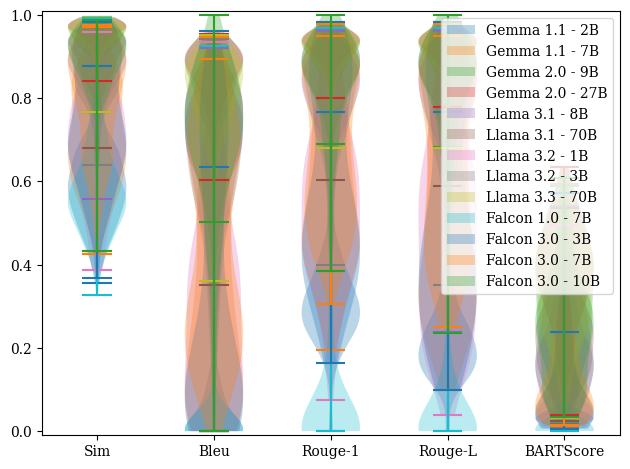

In [10]:
hs, ls = [], []

print(f'{" "*15} & Validity & $k@\epsilon=1e-9$ & Probability & Similarity & BLEU & ROUGE-1 & ROUGE-L & BARTScore &    dt \\\\')
for model in counterfactuals:
    cf = counterfactuals[model][1].copy()
    cf['bart-score'] = np.exp(cf['bart-score'].values)
    
    hs.append(plt.violinplot(cf[['similarity', 'bleu', 'rouge1-f1', 'rougeL-f1', 'bart-score']][cf.success.values].values)['bodies'][0])
    ls.append(model)

    print(f'{model}{" "*(15-len(model))} & ' +
        f'{cf["success"].values.mean():8.2f} & ' +
        f'{np.ceil(np.emath.logn((1 - cf.success.values.mean()), 1e-9)):17.0f} & ' +
        f'{cf["probability"][cf.success.values].mean():11.2f} & ' +
        f'{cf["similarity"][cf.success.values].mean():10.2f} & ' +
        f'{cf["bleu"][cf.success.values].mean():6.2f} & ' +
        f'{cf["rouge1-f1"][cf.success.values].mean():7.2f} & ' +
        f'{cf["rougeL-f1"][cf.success.values].mean():7.2f} & ' +
        f'{cf["bart-score"][cf.success.values].mean():9.2f} & ' +
        f'{cf["dt"][cf.success.values].mean():5.2f} \\\\'
    )

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['Sim', 'Bleu', 'Rouge-1', 'Rouge-L', 'BARTScore'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

## Best successfull cf:

In [11]:
for model in counterfactuals: print(model, '\n', counterfactuals[model][K].describe(), '\n')

Gemma 1.1 - 2B 
        Unnamed: 0  probability  similarity           bleu  rouge1-rec  \
count  200.000000   200.000000  200.000000   2.000000e+02  200.000000   
mean    99.500000     0.142892    0.595563   4.040526e-02    0.233414   
std     57.879185     0.272586    0.095939   7.934216e-02    0.129785   
min      0.000000     0.001930    0.340426   0.000000e+00    0.000000   
25%     49.750000     0.010986    0.533703  1.627183e-155    0.160283   
50%     99.500000     0.038330    0.589200   8.680350e-79    0.237229   
75%    149.250000     0.081421    0.660130   5.874445e-02    0.310536   
max    199.000000     0.878906    0.821705   4.774884e-01    0.666667   

       rouge1-prc   rouge1-f1  rougeL-rec  rougeL-prc   rougeL-f1  bart-score  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.375316    0.278891    0.168023    0.266879    0.199727   -3.940278   
std      0.173893    0.137698    0.109071    0.139208    0.114546    1.501754   
m

                & Validity & Probability & Similarity & BLEU & ROUGE-1 & ROUGE-L & BARTScore &    dt \\
Gemma 1.1 - 2B  &     1.00 &        0.14 &       0.60 &   0.04 &    0.28 &    0.20 &      0.03 &  9.14 \\
Gemma 1.1 - 7B  &     1.00 &        0.42 &       0.74 &   0.36 &    0.60 &    0.54 &      0.13 & 28.00 \\
Gemma 2.0 - 9B  &     0.81 &        0.98 &       0.95 &   0.83 &    0.91 &    0.91 &      0.34 & 65.36 \\
Gemma 2.0 - 27B &     0.83 &        0.99 &       0.97 &   0.85 &    0.92 &    0.92 &      0.39 & 84.01 \\
Llama 3.1 - 8B  &     0.99 &        0.94 &       0.91 &   0.73 &    0.86 &    0.86 &      0.24 & 28.47 \\
Llama 3.1 - 70B &     1.00 &        0.94 &       0.93 &   0.77 &    0.89 &    0.88 &      0.27 & 183.55 \\
Llama 3.2 - 1B  &     0.98 &        0.57 &       0.77 &   0.45 &    0.65 &    0.61 &      0.11 & 21.83 \\
Llama 3.2 - 3B  &     0.96 &        0.83 &       0.88 &   0.66 &    0.81 &    0.79 &      0.21 & 29.12 \\
Llama 3.3 - 70B &     0.93 &        1.00 &     

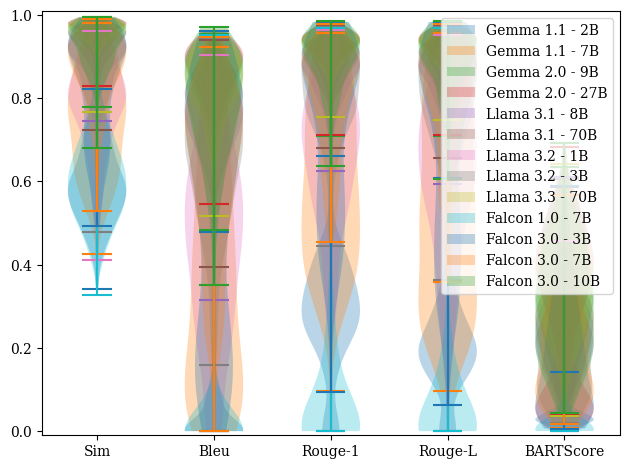

In [12]:
hs, ls = [], []

print(f'{" "*15} & Validity & Probability & Similarity & BLEU & ROUGE-1 & ROUGE-L & BARTScore &    dt \\\\')
for model in counterfactuals:
    cf = counterfactuals[model][K].copy()
    cf['bart-score'] = np.exp(cf['bart-score'].values)
    
    hs.append(plt.violinplot(cf[['similarity', 'bleu', 'rouge1-f1', 'rougeL-f1', 'bart-score']][cf.success.values].values)['bodies'][0])
    ls.append(model)

    print(f'{model}{" "*(15-len(model))} & ' +
        f'{cf["success"].values.mean():8.2f} & ' +
        f'{cf["probability"][cf.success.values].mean():11.2f} & ' +
        f'{cf["similarity"][cf.success.values].mean():10.2f} & ' +
        f'{cf["bleu"][cf.success.values].mean():6.2f} & ' +
        f'{cf["rouge1-f1"][cf.success.values].mean():7.2f} & ' +
        f'{cf["rougeL-f1"][cf.success.values].mean():7.2f} & ' +
        f'{cf["bart-score"][cf.success.values].mean():9.2f} & ' +
        f'{cf["dt"][cf.success.values].mean():5.2f} \\\\'
    )

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['Sim', 'Bleu', 'Rouge-1', 'Rouge-L', 'BARTScore'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

# Statistical Tests:

$p$-value < $\alpha~\rightarrow$ reject $H_0$

Used tests:
 - Shapiro-Wilk: $H_0$ = "`a` is normally distributed."
 - Wilcoxon signed-rank test: $H_0$ = "`a`-`b` is symmetric about $\mu = 0$."

In [13]:
from scipy.stats import shapiro, wilcoxon

In [14]:
def normality_of_differnces(a, b, alpha=.05):
    W, p = shapiro(a-b)
    return p > alpha, 'There is' + (' NO ' if p > alpha else ' ') + f'evidence that the differences are not normally distributed (%alpha={alpha:.2f}, p={p:.3f})'
    

In [15]:
ALPHA = 0.05

## Best better than first:

In [16]:
dt_analysis = {}
for model in RESULTS:
    dt_first = counterfactuals[model][1]['dt'].values
    dt_best  = counterfactuals[model][K]['dt'].values

    # first vs. best:
    normal, msg = normality_of_differnces(dt_first, dt_best, alpha=ALPHA)
    print(f'{model}: {msg}')
    
    t, p = wilcoxon(dt_first, dt_best, alternative='less')

    dt_analysis[model] = {
        '$min_{first}$': f'{dt_first.min():.2f}', '$\mu_{first}$': f'{dt_first.mean():.2f}', '$max_{first}$': f'{dt_first.max():.2f}',
        '$min_{best}$': f'{dt_best.min():.2f}',   '$\mu_{best}$': f'{dt_best.mean():.2f}',   '$max_{best}$': f'{dt_best.max():.2f}',
        '$dt_{first}~<~dt_{best}$': (p < ALPHA),
        '$p-value~(dt_{first}~<~dt_{best})$': f'{p:.3f}',
    }

dt_analysis = pd.DataFrame(dt_analysis).T

dt_analysis

Gemma 1.1 - 2B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=nan)
Gemma 1.1 - 7B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=nan)
Gemma 2.0 - 9B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 27B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 8B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=nan)
Llama 3.1 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=nan)
Llama 3.2 - 1B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=nan)
Llama 3.2 - 3B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=nan)
Llama 3.3 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=nan)
Falcon 1.0 - 7B: There is evidence that the diff

,$min_{first}$,$\mu_{first}$,$max_{first}$,$min_{best}$,$\mu_{best}$,$max_{best}$,$dt_{first}~<~dt_{best}$,$p-value~(dt_{first}~<~dt_{best})$
Gemma 1.1 - 2B,0.45,1.14,2.22,nan,nan,nan,False,nan
Gemma 1.1 - 7B,0.80,2.97,6.01,nan,nan,nan,False,nan
Gemma 2.0 - 9B,2.18,6.53,10.56,20.41,65.43,105.61,True,0.000
Gemma 2.0 - 27B,2.84,8.51,13.80,27.98,85.16,138.09,True,0.000
Llama 3.1 - 8B,0.86,3.59,6.13,nan,nan,nan,False,nan
Llama 3.1 - 70B,3.98,17.80,30.20,nan,nan,nan,False,nan
Llama 3.2 - 1B,0.30,2.22,3.02,nan,nan,nan,False,nan
Llama 3.2 - 3B,0.78,3.10,5.20,nan,nan,nan,False,nan
Llama 3.3 - 70B,4.18,17.30,30.17,nan,nan,nan,False,nan
Falcon 1.0 - 7B,0.35,3.04,30.69,6.76,20.57,58.20,True,0.000


In [17]:
sim_analysis = {}
for model in RESULTS:
    sim_first = counterfactuals[model][1]['similarity'].values
    sim_best  = counterfactuals[model][K]['similarity'].values

    # first vs. best:
    normal, msg = normality_of_differnces(sim_first, sim_best, alpha=ALPHA)
    print(f'{model}: {msg}')
    
    t, p = wilcoxon(sim_first, sim_best, alternative='less')

    sim_analysis[model] = {
        '$min_{first}$': f'{sim_first.min():.2f}', '$\mu_{first}$': f'{sim_first.mean():.2f}', '$max_{first}$': f'{sim_first.max():.2f}',
        '$min_{best}$': f'{sim_best.min():.2f}',   '$\mu_{best}$': f'{sim_best.mean():.2f}',   '$max_{best}$': f'{sim_best.max():.2f}',
        '$sim_{first}~<~sim_{best}$': (p < ALPHA),
        '$T~(sim_{first}~<~sim_{best})$': f'{t:.3f}',
        '$p-value~(sim_{first}~<~sim_{best})$': f'{p:.3f}',
    }

sim_analysis = pd.DataFrame(sim_analysis).T

sim_analysis

Gemma 1.1 - 2B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 1.1 - 7B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 9B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 27B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 8B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.2 - 1B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.007)
Llama 3.2 - 3B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.3 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Falcon 1.0 - 7B: There is evidence

,$min_{first}$,$\mu_{first}$,$max_{first}$,$min_{best}$,$\mu_{best}$,$max_{best}$,$sim_{first}~<~sim_{best}$,$T~(sim_{first}~<~sim_{best})$,$p-value~(sim_{first}~<~sim_{best})$
Gemma 1.1 - 2B,0.36,0.60,0.88,0.34,0.60,0.82,False,5990.000,0.185
Gemma 1.1 - 7B,0.43,0.72,0.97,0.43,0.74,0.98,True,4885.000,0.000
Gemma 2.0 - 9B,0.77,0.96,1.00,0.78,0.95,1.00,False,6768.000,0.840
Gemma 2.0 - 27B,0.80,0.96,1.00,0.81,0.97,0.99,False,5102.000,0.257
Llama 3.1 - 8B,0.56,0.87,0.99,0.74,0.91,0.99,True,2094.000,0.000
Llama 3.1 - 70B,0.68,0.91,0.99,0.72,0.93,0.99,True,1194.000,0.000
Llama 3.2 - 1B,0.39,0.71,0.96,0.41,0.77,0.96,True,4477.000,0.000
Llama 3.2 - 3B,0.64,0.89,1.00,0.48,0.88,0.99,False,8514.000,0.988
Llama 3.3 - 70B,0.77,0.95,1.00,0.77,0.96,0.99,True,1553.000,0.000
Falcon 1.0 - 7B,0.33,0.62,1.00,0.33,0.61,0.99,False,4839.000,0.595


In [18]:
prob_analysis = {}
for model in RESULTS:
    prob_first = counterfactuals[model][1]['similarity'].values
    prob_best  = counterfactuals[model][K]['similarity'].values

    # first vs. best:
    normal, msg = normality_of_differnces(prob_first, prob_best, alpha=ALPHA)
    print(f'{model}: {msg}')
    
    t, p = wilcoxon(prob_first, prob_best, alternative='less')

    prob_analysis[model] = {
        '$min_{first}$': f'{prob_first.min():.2f}', '$\mu_{first}$': f'{prob_first.mean():.2f}', '$max_{first}$': f'{prob_first.max():.2f}',
        '$min_{best}$': f'{prob_best.min():.2f}',   '$\mu_{best}$': f'{prob_best.mean():.2f}',   '$max_{best}$': f'{prob_best.max():.2f}',
        '$p_{first}~<~p_{best}$': (p < ALPHA),
        '$T~(p_{first}~<~p_{best})$': f'{t:.3f}',
        '$p-value~(p_{first}~<~p_{best})$': f'{p:.3f}',
    }

prob_analysis = pd.DataFrame(prob_analysis).T

prob_analysis

Gemma 1.1 - 2B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 1.1 - 7B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 9B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Gemma 2.0 - 27B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 8B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.1 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.2 - 1B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.007)
Llama 3.2 - 3B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Llama 3.3 - 70B: There is evidence that the differences are not normally distributed (%alpha=0.05, p=0.000)
Falcon 1.0 - 7B: There is evidence

,$min_{first}$,$\mu_{first}$,$max_{first}$,$min_{best}$,$\mu_{best}$,$max_{best}$,$p_{first}~<~p_{best}$,$T~(p_{first}~<~p_{best})$,$p-value~(p_{first}~<~p_{best})$
Gemma 1.1 - 2B,0.36,0.60,0.88,0.34,0.60,0.82,False,5990.000,0.185
Gemma 1.1 - 7B,0.43,0.72,0.97,0.43,0.74,0.98,True,4885.000,0.000
Gemma 2.0 - 9B,0.77,0.96,1.00,0.78,0.95,1.00,False,6768.000,0.840
Gemma 2.0 - 27B,0.80,0.96,1.00,0.81,0.97,0.99,False,5102.000,0.257
Llama 3.1 - 8B,0.56,0.87,0.99,0.74,0.91,0.99,True,2094.000,0.000
Llama 3.1 - 70B,0.68,0.91,0.99,0.72,0.93,0.99,True,1194.000,0.000
Llama 3.2 - 1B,0.39,0.71,0.96,0.41,0.77,0.96,True,4477.000,0.000
Llama 3.2 - 3B,0.64,0.89,1.00,0.48,0.88,0.99,False,8514.000,0.988
Llama 3.3 - 70B,0.77,0.95,1.00,0.77,0.96,0.99,True,1553.000,0.000
Falcon 1.0 - 7B,0.33,0.62,1.00,0.33,0.61,0.99,False,4839.000,0.595
